# CICERO SCM notebook parallel example

Import some stuff and import the model

In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

# NBVAL_IGNORE_OUTPUT
#from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions
from ciceroscm.parallel.cscmparwrapper import run_ciceroscm_parallel
import ciceroscm.input_handler as input_handler


import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import torch, torch.nn as nn, torch.utils.data as td
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.utils.data as td
import time

/home/obola/repositories/cicero-scm-surrogate/ciceroscm/notebooks/../src/ciceroscm/parallel/_parallel_process.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Define data directory

In [2]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

Define emissions data

In [10]:

gaspam_data = input_handler.read_components(
    os.path.join(test_data_dir, "gases_v1RCMIP.txt")
)

conc_data = input_handler.read_inputfile(
    os.path.join(test_data_dir, "ssp245_conc_RCMIP.txt"), True, 1750, 2100
)
ih = input_handler.InputHandler({"nyend": 2075, "nystart": 1900, "emstart": 2015})
em_data = ih.read_emissions(os.path.join(test_data_dir, "ssp245_em_RCMIP.txt"))
nat_ch4_data = input_handler.read_natural_emissions(
    os.path.join(test_data_dir, "natemis_ch4.txt"), "CH4"
)
nat_n2o_data = input_handler.read_natural_emissions(
    os.path.join(test_data_dir, "natemis_n2o.txt"), "N2O"
)

Make a list of dictionaries to define the parameter ensemble - keys should be pamset_udm, pamset_emiconc and Index...

In [11]:
cfgs = [
    {
        "pamset_udm": {
            "rlamdo": 15.08357,
            "akapa": 0.6568376339229769,
            "cpi": 0.2077266,
            "W": 2.205919,
            "beto": 6.89822,
            "lambda": 0.6062529,
            "mixed": 107.2422,
        },
        "pamset_emiconc": {
            "qbmb": 0.0,
            "qo3": 0.5,
            "qdirso2": -0.3562,
            "qindso2": -0.96609,
            "qbc": 0.1566,
            "qoc": -0.0806,
        },
        "Index": "13555_old_NR_improved",
    }
]

Define scenarios as a list of dictionaries.

In [12]:
emstart_year = 2015
nyend        = 2075
scenarios    = []

# Default: ultra-tight ±0.5 %
tight_bounds = (0.995, 1.005)

# Looser ±3 % for headline gases
loose_bounds = {
    "CO2_FF":   (0.95, 1.05),
    "CO2_AFOLU":(0.95, 1.05),
    "CH4":      (0.95, 1.05),
    "N2O":      (0.95, 1.05)
}

# 1) year-over-year baseline multipliers  E_t / E_{t-1}
shifted      = em_data.shift(1)
growth_base  = em_data.divide(shifted.replace(0, np.nan))
growth_base  = growth_base.replace([np.inf, -np.inf], np.nan).fillna(1.0)

years_future = np.arange(emstart_year, nyend + 1)
gas_cols     = em_data.columns

for k in range(1):
    # --- 2) random ±5 % growth-rate perturbations --------------------------
    # Each element ~ U(0.95, 1.05)
    rng   = np.random.default_rng(seed=k)        # reproducible
    
    # container for this scenario’s factors
    delta = np.empty((len(years_future), len(gas_cols)), dtype=float)

    for j, gas in enumerate(gas_cols):
        lo, hi = loose_bounds.get(gas, tight_bounds)        # pick bounds
        delta[:, j] = rng.uniform(lo, hi, size=len(years_future))

    scale_df = pd.DataFrame(delta, index=years_future, columns=gas_cols)
    # --- 3) build absolute emissions path ---------------------------------
    em_scaled = em_data.copy()
    # for t in years_future:
    #     gfactor = growth_base.loc[t] * scale_df.loc[t]        # modified YoY
    #     em_scaled.loc[t] = em_scaled.loc[t-1] * gfactor       # E_t = E_{t-1}·g

    # --- 4) package scenario dict -----------------------------------------
    new_scen = {
        "gaspam_data": gaspam_data,
        "nyend": nyend,
        "nystart": 1900,
        "emstart": emstart_year,
        "concentrations_data": conc_data,
        "nat_ch4_data": nat_ch4_data,
        "nat_n2o_data": nat_n2o_data,
        "emissions_data": em_scaled,          # absolute values rebuilt above
        "udir": test_data_dir,
        "idtm": 24,
        "scenname": f"rw_growth±5pct_{k:03d}",
    }
    scenarios.append(new_scen)

Parallel processor loops over all scenarios and configuration lists

In [13]:
# NBVAL_IGNORE_OUTPUT
output_variables = ["Surface Air Temperature Change",
                    #"Heat Content|Ocean", 
                    ]

start_time = time.time()
results = run_ciceroscm_parallel(scenarios, cfgs, output_variables)
end_time = time.time()

print(f"Total time for the run: {end_time-start_time}")

Parallel runs:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Total time for the run: 0.6745095252990723


In [15]:
results.to_csv("baseline_results_v2.csv")

Look at the output openSCMrunner object

Plot some plume plots, showing the range of temperature for each scenario (looking at percentiles of the parameter response distribution)

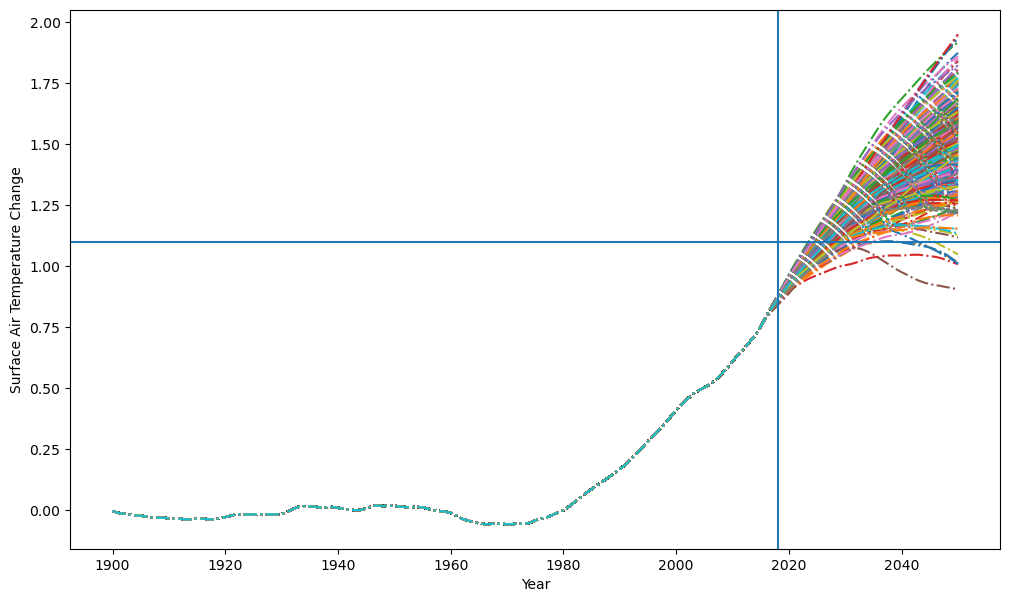

In [7]:

# NBVAL_IGNORE_OUTPUT
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
for name, group in results[results["variable"]=="Surface Air Temperature Change"].groupby("scenario"):
    ax.plot(group.columns[7:], group.iloc[:, 7:].quantile(0.5), '-.', label = name)
    ax.fill_between(group.columns[7:].astype(int), group.iloc[:, 7:].quantile(0.05).astype(float), group.iloc[:, 7:].quantile(0.95).astype(float), alpha = 0.3)

ax.set_xlabel("Year")
ax.set_ylabel("Surface Air Temperature Change")
#ax.legend()
ax.axhline(1.1)
ax.axvline(2018)

In [43]:
WINDOW   = 50
GASES    = scenarios[0]["emissions_data"].columns.tolist()
G        = len(GASES)
EMSTART  = 2015                        # first year we predict

# 1 ─ pull temperature rows once
temp_tbl = (
    results[ results["variable"] == "Surface Air Temperature Change" ]
    .set_index("scenario")          # index by scenario
    .filter(regex=r"^\d")           # keep only year columns
    .astype(float)
)

# 2 - Split scenarios into training and validation sets
train_scenarios, val_scenarios = train_test_split(scenarios, test_size=0.15, random_state=0, shuffle=True)


# 3 - Function to generate data for a set of scenarios
def generate_data(scenario_list):
    X_list, y_list = [], []
    for scen in scenario_list:
        name  = scen["scenname"]
        em_df = scen["emissions_data"]      # absolute levels
        years = em_df.index                 # 1900 … 2050

        T_air = temp_tbl.loc[name, years].to_numpy()

        # loop so that target year (t+1) ≥ 2015
        for t_idx in range(WINDOW, len(years)-1):
            t_target = years[t_idx+1]       # this is year we’ll predict
            if t_target < EMSTART:
                continue                    # skip 1900–2014 targets

            hist = em_df.loc[t_target-WINDOW : t_target-1, GASES].to_numpy()
            next_em  = em_df.loc[t_target, GASES].to_numpy()
            X_sample = np.vstack([hist, next_em[None, :]]).astype("float32")  # (51,G)
            y      = np.float32(T_air[t_idx+1])                             # scalar

            X_list.append(X_sample)
            y_list.append(y)
    
    # convert to arrays
    X = np.stack(X_list)
    y = np.stack(y_list)
    return X, y

# 4 - Create training and validation sets
X_train, y_train = generate_data(train_scenarios)
X_val, y_val = generate_data(val_scenarios)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])

Training samples: 12240
Validation samples: 2160


In [44]:
# X has shape (N, 51, G)
G = X_train.shape[2]

mu  = X_train.reshape(-1, G).mean(axis=0)     # per-gas mean
std = X_train.reshape(-1, G).std(axis=0) + 1e-6

def norm(a): return (a - mu) / std
X_train_norm = norm(X_train)
X_val_norm = norm(X_val)


train_ds = td.TensorDataset(torch.tensor(X_train_norm), torch.tensor(y_train))
val_ds   = td.TensorDataset(torch.tensor(X_val_norm),   torch.tensor(y_val))

train_loader = td.DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = td.DataLoader(val_ds,   batch_size=64)

In [45]:
class GRUSurrogate(nn.Module):
    def __init__(self, n_gas, hidden=64):
        super().__init__()
        self.gru = nn.GRU(n_gas, hidden, batch_first=True)
        self.out = nn.Sequential(nn.Linear(hidden + n_gas, 64),
                                 nn.SiLU(),
                                 nn.Linear(64, 1))          # ΔT_air only
    def forward(self, x):                 # x shape (B, 51, G)
        hist, action = x[:, :-1, :], x[:, -1, :]
        h_last,_ = self.gru(hist)         # (B,50,H) → take last step
        h_last  = h_last[:, -1, :]        # (B,H)
        y_hat   = self.out(torch.cat([h_last, action], dim=-1)).squeeze(1)
        return y_hat

In [46]:
# ── model / optimiser / loss / scheduler ───────────────────────────────
device  = "cuda" if torch.cuda.is_available() else "cpu"
model   = GRUSurrogate(G).to(device)

opt         = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(
                 opt, mode="min", factor=0.5, patience=5,
                 min_lr=1e-5)

criterion = nn.MSELoss()

def validation_metrics(loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            y_true.append(yb.cpu().numpy())
            y_pred.append(model(xb).view(-1).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "R2": r2}

# ── training loop ──────────────────────────────────────────────────────
EPOCHS = 200
pbar   = tqdm(range(1, EPOCHS + 1), desc="epochs")

for epoch in pbar:
    # training
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        opt.step()

    # validation
    model.eval()
    val = validation_metrics(val_loader)

    # scheduler step on validation RMSE
    scheduler.step(val["RMSE"])
    current_lr = opt.param_groups[0]["lr"]

    # progress-bar postfix
    pbar.set_postfix({
        "val_RMSE": f"{val['RMSE']:.4f}°C",
        "val_R²":   f"{val['R2']:.3f}",
        "lr":       f"{current_lr:.1e}"
    })

epochs:   0%|          | 0/200 [00:00<?, ?it/s]

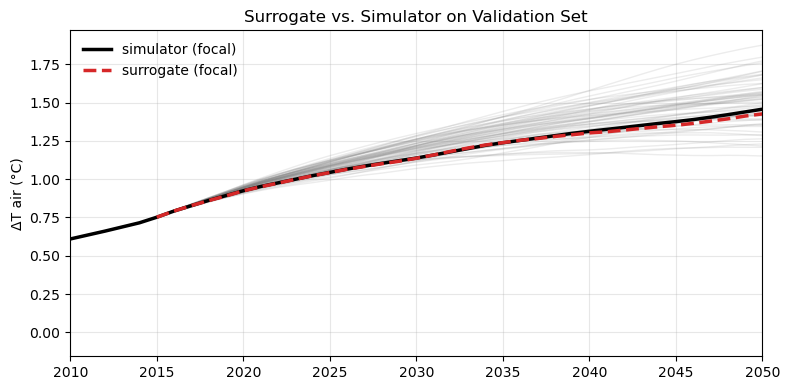

In [73]:
def sim_temp(scen_name, years_int):
    """Return simulator ΔTair as a NumPy array for the given years."""
    row = results.query(
        "scenario == @scen_name and variable == 'Surface Air Temperature Change'"
    ).iloc[0]                                  # Series with mixed columns

    # keep only columns whose labels are all digits  (year columns)
    year_cols = [c for c in row.index if str(c).isdigit()]
    row_years = row[year_cols].astype(float)
    row_years.index = row_years.index.astype(int)   # now Int64Index

    return row_years.loc[years_int].to_numpy()

def surrogate_temp(em_df, years):
    out = [np.nan]*WINDOW
    for t in years[WINDOW:]:
        if t < 2015:
            out.append(np.nan); continue
        hist = em_df.loc[t-WINDOW:t-1, GASES].to_numpy("float32")
        action = em_df.loc[t,          GASES].to_numpy("float32")
        x_norm = (np.vstack([hist, action[None,:]]) - mu) / std
        xb     = torch.tensor(x_norm[None,...], device=device)
        with torch.no_grad():
            out.append(model(xb).item())
    return np.array(out)

# --------- pick scenarios -------------------------------------------------
focal      = val_scenarios[7]
extra_list = val_scenarios[1:]                     # other validation scenarios

years = focal["emissions_data"].index

# focal data
T_sim_f   = sim_temp(focal["scenname"], years)
T_pred_f  = surrogate_temp(focal["emissions_data"], years)

# --------- plot -----------------------------------------------------------
plt.figure(figsize=(8,4))

# extras first, faint
for s in extra_list:
    T_sim = sim_temp(s["scenname"], years)
    plt.plot(years, T_sim,  color="gray",      alpha=0.15, linewidth=1)

# focal bold
plt.plot(years, T_sim_f,  color="black",   lw=2.5, label="simulator (focal)")
plt.plot(years, T_pred_f, color="tab:red", lw=2.5, ls="--", label="surrogate (focal)")

plt.xlim(2010, 2050)
plt.ylabel("ΔT air (°C)")
plt.title("Surrogate vs. Simulator on Validation Set")
plt.legend(frameon=False); plt.grid(alpha=0.3); plt.tight_layout()